# MI vs OR

This notebook uses simulation to show the relationship between mutual information and odds ratio. The purpose of the notebook is to support the idea that mutual information is superior to odds ratio because it offers almost all of what odds ratios can but without the need to assume any model relating the variables. The loss of directionality that is offered by odds ratios is not of concern when our focus is on identifying _any_ relationships between variables.

First, we load all packages that we need.

In [30]:
list_of_packages <- c("tidyverse", "infotheo", "epitools", "ggplot2")
new_packages <- list_of_packages[!(list_of_packages %in% installed.packages()[,"Package"])]
if(length(new_packages)) install.packages(new_packages)
for (i in 1:length(list_of_packages))
{
  library(list_of_packages[i],character.only = T)
}

The bulk of the work is done within an IF statement that asks whether the "MI vs OR_low sample.RDS" already exists. If the file exists, then load it. If not, then create it.

In [47]:
if (file.exists("OR vs MI_low sample.RDS"))
    {
        myTable <- readRDS("OR vs MI_low sample.RDS")
    }else
    {
      # Define table of showing unique values for variable combinations
      tallyTable <- expand.grid(x = c(0,1), y = c(0,1))

      # Define the range of tallies for each row of tallyTable.
      t00 <- c(10, 100, 1000, 10000)
      t01 <- t00
      t10 <- t00
      t11 <- t00

      # Define storage table.
      myTable <- expand.grid(`00` = t00, `01` = t01, `10` = t10, `11` = t11)
      myTable$OddsRatio <- numeric(nrow(myTable))
      myTable$MutInfo <- numeric(nrow(myTable))
      myTable$MutInfo_scaled <- numeric(nrow(myTable))

      count <- 1
      for (a in 1:length(t00))
      {
        for (b in 1:length(t01))
        {
          for (c in 1:length(t10))
          {
            for (d in 1:length(t11))
            {
              # Make i-th dataset.
              i_data <- 
                rbind(
                  tallyTable[rep(1, times = t00[a]),],
                  tallyTable[rep(2, times = t01[b]),],
                  tallyTable[rep(3, times = t10[c]),],
                  tallyTable[rep(4, times = t11[d]),]
                )

              if (nrow(i_data) > 0)
              {
                # Calculate and store odds ratio (Wald: unconditional MLE).
                myTable$OddsRatio[count] <- 
                  epitools::oddsratio.wald(table(i_data))$measure[2]

                # Calculate and store mutual information.    
                myTable$MutInfo[count] <-
                  infotheo::mutinformation(X = i_data[,1], Y = i_data[,2])
                
                # Calculate and store scaled mutual information.    
                myTable$MutInfo_scaled[count] <-
                  myTable$MutInfo[count] / 
                  min(infotheo::entropy(X = i_data[,1], verbose = FALSE), infotheo::entropy(X = i_data[,2], verbose = FALSE))
              }

              # Update count.
              count = count + 1
            } # End d.
          } # End c.
        } # End b.
      } # End a.

      # Transform values for plotting.
      myTable$log_OR <- log(myTable$OddsRatio, exp(1))
      # Save file
      saveRDS(myTable, file = "OR vs MI_low sample.RDS")
    }

With the RDS file loaded, we can begin plotting.

The first figure shows odds ratio against mutual information:
- __horiztonal axis__ = Odds ratio.
    - Note, the axis has been scaled to show the symmetry about 1 clearly. Typically, this view is obfuscated because the symmetry of all odd-ratio values between 1 and ${\infty}$ are crammed into the space between 0 and 1.
- __vertical axis__ = Mutual Information
    - Note, the mutual information value is scaled between 0 and 1, with 1 being the theoretical maximum for this situation with two possible values per variable and calculating logs to the base _e_.

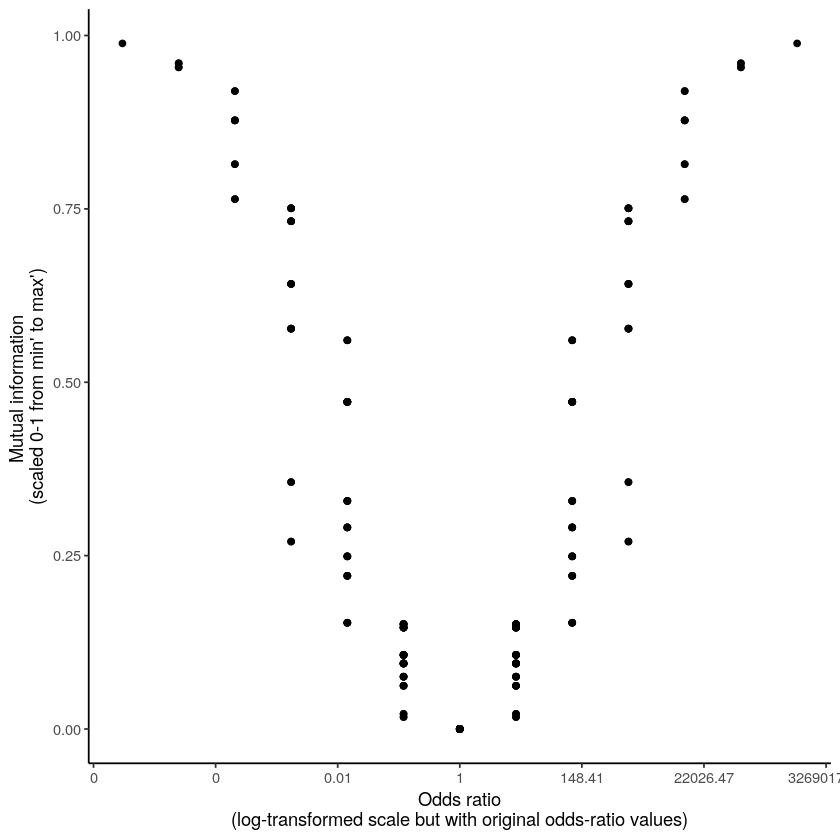

In [43]:
p <- ggplot(myTable, aes(x = log_OR, y = MutInfo_scaled)) +
    geom_point() +
    labs(x = "Odds ratio\n(log-transformed scale but with original odds-ratio values)",
         y = "Mutual information \n(scaled 0-1 from min' to max')") +
    scale_x_continuous(labels =
                       sapply(sapply(seq(from = -15, to = 15, by = 5), exp) %>%
                              round(.,digits = 2), as.character)) +
    theme_classic()
p

Two take-home messages:
1. There can be multiple values for mutual information for any given odds ratio, and vice versa.
2. Mutual information does not distinguish positive and negative odds ratios.



The table and figure below show the range of values for scaled mutual information that correpsond to an odds ratio of 100.

|Min. | 1st Qu. | Median | Mean | 3rd Qu. | Max. |
|----|---------|--------|------|---------|------|
|0.00455| 0.03326| 0.04262| 0.15198| 0.20732| 0.56050 |

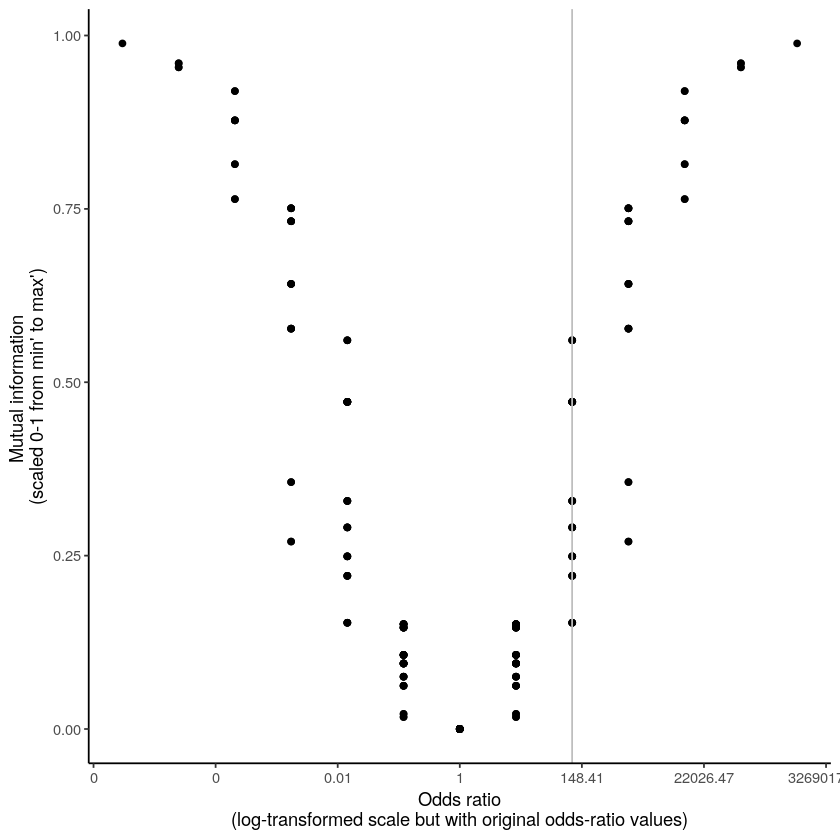

In [44]:
p_vline <- p + geom_vline(xintercept = exp(log(4.6, exp(1))), color = "grey")
p_vline

Vice versa, the table and figure below show the range of values for odds ratios that correpsond to a scaled mutual information of 0.25.

|Min. | 1st Qu. | Median | Mean | 3rd Qu. | Max. |
|----|---------|--------|------|---------|------|
|0.001|0.010|500.00|500.00|100.000|1000.000 |

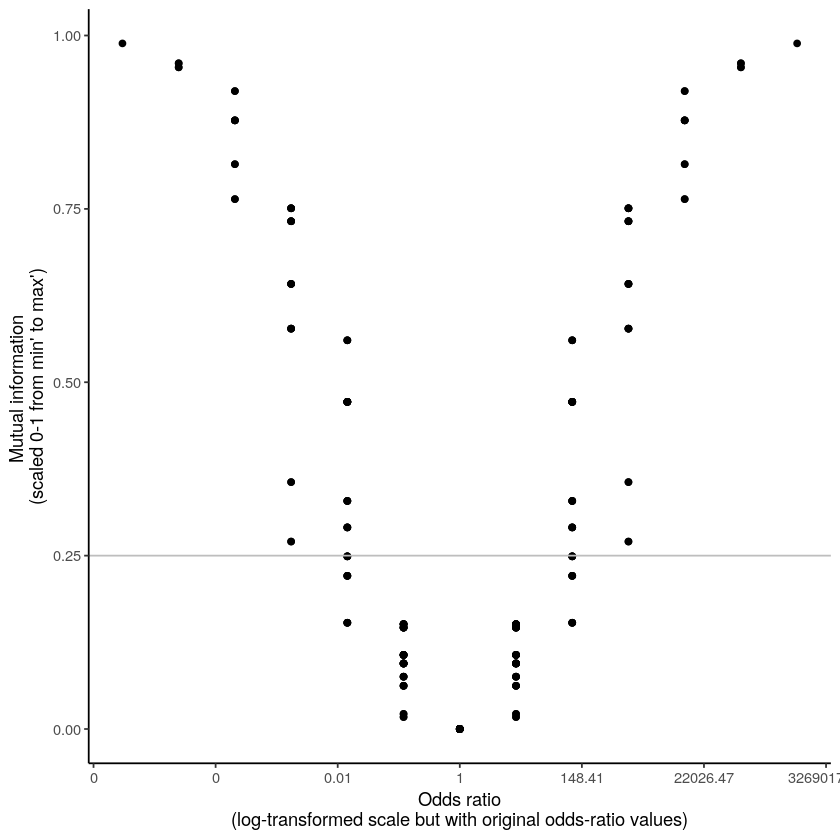

In [45]:
p_hline <- p + geom_hline(yintercept = 0.25, color = "grey")
p_hline

# Benefits of mutual information
- Mutual information captures a wide range of odds ratio values in a compact way.
- Mutual information is as good/poor at distinguishing contingency tables as odds ratios.
- Mutual information offers all of the above without any need to assume a model relating the two variables. 